In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/nfs/users/nfs_e/er10/fonts/arial.ttf',
    name='my_arial')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'

import seaborn as sns
import pandas as pd
import pysam
from liftover import get_lifter
import tabix
from scipy import stats
from scipy.stats import chisquare
import scikit_posthocs as sp
%matplotlib inline

In [3]:
def collect_data(row):
    cons=row['Primary_consequence']
    uniq=row['SGE_oligo_name']
    cluster=row['SGE_functional_classification']
    D7=row['D7_combined_LFC']
    D11=row['D11_combined_LFC']
    D15=row['D15_combined_LFC']
    data_summary[uniq]=(cons, cluster, 0, D7, D11, D15)

In [4]:
data_root='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Revised/'
out_files='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots/'

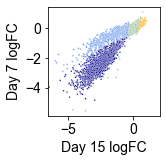

In [5]:
# Fig 2A
df=pd.read_csv(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', header=0, sep='\t',index_col=False)
not_snvre=df.query('Variant_design_type!="snvre"')

color_dict = {'unchanged':'darkseagreen', 'enriched':'orange', 'fast depleting':'darkblue', 'slow depleting': 'cornflowerblue'}
fig, ax = plt.subplots()
ax.set_xlabel('Day 15 logFC', fontsize=14)
ax.set_ylabel('Day 7 logFC', fontsize=14)
ax.set_xlim(-6.5,2)
fig.set_size_inches(2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g=sns.scatterplot(data=df, x='D15_combined_LFC', y='D7_combined_LFC', hue='SGE_functional_classification', marker='.', palette = color_dict, s=10, legend=False)
plt.savefig(out_files+'Fig2A_scatterplot_Dynamic_cluster.pdf', dpi=1300, bbox_inches='tight', transparent=True)


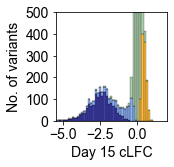

In [8]:
color_dict = {'unchanged':'darkseagreen', 'enriched':'orange', 'fast depleting':'darkblue', 'slow depleting': 'cornflowerblue'}
fig, ax = plt.subplots()
ax.set_xlabel('Day 15 cLFC', fontsize=14)
ax.set_ylabel('No. of variants', fontsize=14)
ax.set_xlim(-5.5,2)
ax.set_ylim(0,500)
fig.set_size_inches(2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g=sns.histplot(data=df, x="D15_combined_LFC", hue="SGE_functional_classification", palette=color_dict, binwidth=0.15, edgecolor="k", legend=False, multiple='stack', fill=True)
plt.savefig(out_files+'Fig2B_scatterplot_Dynamic_cluster_cropped.pdf', dpi=1300, bbox_inches='tight', transparent=True)


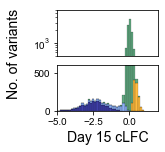

In [9]:
# Fig 2B
color_dict = {'unchanged':'seagreen', 'enriched':'orange', 'fast depleting':'darkblue', 'slow depleting': 'cornflowerblue'}

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True)
f.set_size_inches(2,2)
ax1 = sns.histplot(data=df, x="D15_combined_LFC", hue="SGE_functional_classification", palette=color_dict, binwidth=0.15, edgecolor="k", legend=False, multiple='stack', fill=True,  ax=ax1)

ax2 = sns.histplot(data=df, x="D15_combined_LFC", hue="SGE_functional_classification", palette=color_dict, binwidth=0.15, edgecolor="k", legend=False, multiple='stack', fill=True, ax=ax2)

ax1.set_ylim(500, 6000)
ax2.set_ylim(0, 600)
ax2.set_xlim(-5, 2)
ax1.set(yscale="log")

# share x axis
ax1.get_xaxis().set_visible(False)

# first, remove the y label for both subplots
ax1.set_ylabel("")
ax2.set_ylabel("")
ax2.set_xlabel("Day 15 cLFC", fontsize=14)
# write a new label on the plot 
f.text(-0.198, 0.55, "No. of variants", va="center", rotation="vertical", fontsize=14)

ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

# finally, adjust 
f.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

plt.show()

f.savefig(out_files+'Fig2B_histplot_Dynamic_cluster.pdf', dpi=1300, bbox_inches='tight')


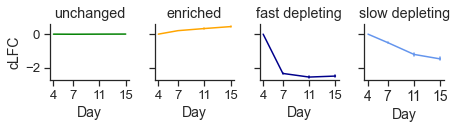

In [17]:
data_summary={}
df.apply(collect_data, axis=1)
    
with open(data_root+'LFC_forFig2C.txt', 'w') as out:
    header='\t'.join(['SGE_oligo_name', 'Primary_consequence','SGE_functional_classification','Day','Combined_LFC'])+'\n'
    out.write(header)
    for uniq in data_summary:
        cons, cluster, D4, D7, D11, D15 = data_summary[uniq]
        line1='\t'.join([uniq, cons, cluster, '4', str(D4)])+'\n'
        line2='\t'.join([uniq, cons, cluster, '7', str(D7)])+'\n'
        line3='\t'.join([uniq, cons, cluster, '11', str(D11)])+'\n'
        line4='\t'.join([uniq, cons, cluster, '15', str(D15)])+'\n'
        out.write(line1)
        out.write(line2)
        out.write(line3)
        out.write(line4)

df=pd.read_csv(data_root+'LFC_forFig2C.txt', header=0, sep='\t',index_col=False)

color_dict={'fast depleting': 'darkblue', 'unchanged':'green','enriched':'orange', 'slow depleting':'cornflowerblue'}
sns.set(font="my_arial", style='ticks', font_scale = 1.2)

g = sns.relplot(
    data=df, x="Day", y="Combined_LFC", col='SGE_functional_classification', kind="line", ci=95, err_style = "bars", hue='SGE_functional_classification', height=1.75, aspect=0.9,
    palette = color_dict, col_order=['unchanged', 'enriched', 'fast depleting', 'slow depleting'], legend=False)
g.set_axis_labels("Day", "cLFC", fontsize=14)
g.set_titles("{col_name}", fontsize=14)
plt.xticks([4,7, 11,15],['4', '7','11', '15'], fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(out_files+'/Fig2C_relplot_Dynamic_cluster.pdf', dpi=1300, bbox_inches='tight', transparent=True)


number nonsense variants 280 unchanged 12 FD 251 SD 14 E 3

number synonymous variants 1301 unchanged 1271 FD 4 SD 10 E 16

number missense variants 4560 unchanged 3309 FD 399 SD 328 E 524

number codon deletions 625 unchanged 269 FD 234 SD 73 E 49

number splice acceptor/donor variants 226 unchanged 51 FD 132 SD 35 E 8


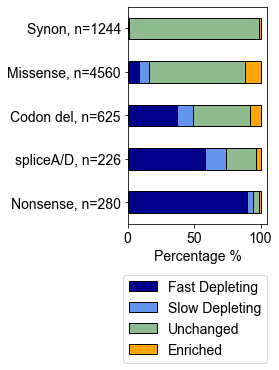

In [8]:
df=pd.read_csv(out_files+'Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', header=0, sep='\t',index_col=False)
df=df.query('Variant_design_type!="snvre"')

Nonsense=df.query('Primary_consequence == "stop_gained"')
Nonsense_fastdep = Nonsense.query('SGE_functional_classification == "fast depleting"')
Nonsense_slowdep = Nonsense.query('SGE_functional_classification == "slow depleting"')
Nonsense_dep = Nonsense.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
Nonsense_enriched = Nonsense.query('SGE_functional_classification == "enriched"')
Nonsense_unchanged = Nonsense.query('SGE_functional_classification == "unchanged"')
print('\nnumber nonsense variants', len(Nonsense), 'unchanged', len(Nonsense_unchanged), 'FD', len(Nonsense_fastdep), 'SD', len(Nonsense_slowdep), 'E', len(Nonsense_enriched))

syn=df.query('Primary_consequence == "synonymous_variant" or "splice_region_variant,synonymous_variant" in Consequence')
syn_fastdep = syn.query('SGE_functional_classification == "fast depleting"')
syn_slowdep = syn.query('SGE_functional_classification == "slow depleting"')
syn_dep = syn.query('SGE_functional_classification== "slow depleting" or SGE_functional_classification == "fast depleting"')
syn_enriched = syn.query('SGE_functional_classification == "enriched"')
syn_unchanged = syn.query('SGE_functional_classification == "unchanged"')
print('\nnumber synonymous variants', len(syn), 'unchanged', len(syn_unchanged), 'FD', len(syn_fastdep), 'SD', len(syn_slowdep), 'E', len(syn_enriched))

miss=df.query('Primary_consequence == "missense_variant"')
miss_fastdep = miss.query('SGE_functional_classification == "fast depleting"')
miss_slowdep = miss.query('SGE_functional_classification == "slow depleting"')
miss_dep = miss.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
miss_enriched = miss.query('SGE_functional_classification == "enriched"')
miss_unchanged = miss.query('SGE_functional_classification == "unchanged"')
print('\nnumber missense variants', len(miss), 'unchanged', len(miss_unchanged), 'FD', len(miss_fastdep), 'SD', len(miss_slowdep), 'E', len(miss_enriched))

inframe= df.query('Primary_consequence == "inframe_deletion"')
inframe_fastdep = inframe.query('SGE_functional_classification == "fast depleting"')
inframe_slowdep = inframe.query('SGE_functional_classification == "slow depleting"')
inframe_dep = inframe.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
inframe_enriched = inframe.query('SGE_functional_classification == "enriched"')
inframe_unchanged = inframe.query('SGE_functional_classification == "unchanged"')
print('\nnumber codon deletions', len(inframe), 'unchanged', len(inframe_unchanged), 'FD', len(inframe_fastdep), 'SD', len(inframe_slowdep), 'E', len(inframe_enriched))

spliceAD= df.query('Primary_consequence == "splice_acceptor_variant" or Primary_consequence == "splice_donor_variant"')
spliceAD_fastdep = spliceAD.query('SGE_functional_classification == "fast depleting"')
spliceAD_slowdep = spliceAD.query('SGE_functional_classification == "slow depleting"')
spliceAD_dep = spliceAD.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
spliceAD_enriched = spliceAD.query('SGE_functional_classification == "enriched"')
spliceAD_unchanged = spliceAD.query('SGE_functional_classification == "unchanged"')
print('\nnumber splice acceptor/donor variants', len(spliceAD), 'unchanged', len(spliceAD_unchanged), 'FD', len(spliceAD_fastdep), 'SD', len(spliceAD_slowdep), 'E', len(spliceAD_enriched))

nonsense_NMD = Nonsense.query('VCF_position > 41341664 and VCF_position < 41347396')
nonsense_NMDe = Nonsense.query('VCF_position >= 41347396')
nonsense_first_200bp = Nonsense.query('VCF_position <= 41341664')
nonsense_first_200bp_dep = nonsense_first_200bp.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
nonsense_dep = Nonsense.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
nonsense_NMD_dep = nonsense_NMD.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')
nonsense_NMDe_dep = nonsense_NMDe.query('SGE_functional_classification == "slow depleting" or SGE_functional_classification == "fast depleting"')

with open (out_files+'/D15_Prop_vars_SGE_functional_classification.txt', 'w') as out:
    header = '\t'.join(['Category', 'Fast Depleting', 'Slow Depleting',  'Unchanged', 'Enriched'])+'\n'
    line1='\t'.join(['Synon, n=1244', str(100*len(syn_fastdep)/len(syn)), str(100*len(syn_slowdep)/len(syn)),   str(100*len(syn_unchanged)/len(syn)), str(100*len(syn_enriched)/len(syn))])+'\n'
    line2='\t'.join(['Missense, n=4560', str(100*len(miss_fastdep)/(len(miss))), str(100*len(miss_slowdep)/(len(miss))),  str(100*len(miss_unchanged)/len(miss)), str(100*len(miss_enriched)/len(miss))])+'\n'
    line3='\t'.join(['Codon del, n=625', str(100*len(inframe_fastdep)/len(inframe)), str(100*len(inframe_slowdep)/len(inframe)),   str(100*len(inframe_unchanged)/len(inframe)), str(100*len(inframe_enriched)/len(inframe))])+'\n'
    line4='\t'.join(['spliceA/D, n=226', str(100*len(spliceAD_fastdep)/len(spliceAD)), str(100*len(spliceAD_slowdep)/len(spliceAD)),   str(100*len(spliceAD_unchanged)/len(spliceAD)), str(100*len(spliceAD_enriched)/len(spliceAD))])+'\n'
    line5='\t'.join(['Nonsense, n=280', str(100*len(Nonsense_fastdep)/len(Nonsense)), str(100*len(Nonsense_slowdep)/len(Nonsense)),   str(100*len(Nonsense_unchanged)/len(Nonsense)), str(100*len(Nonsense_enriched)/len(Nonsense))])+'\n'
    out.write(header)
    out.write(line5)
    out.write(line4)
    out.write(line3)
    out.write(line2)
    out.write(line1)

df = pd.read_csv(out_files+'/D15_Prop_vars_SGE_functional_classification.txt', '\t')
import matplotlib.pyplot as plt
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (2.5,4)
df.plot(
    x = 'Category',edgecolor="k",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=['darkblue','cornflowerblue', 'darkseagreen', 'orange'], mark_right = True, fontsize=14)

plt.title('')
plt.xlabel('Percentage %', fontsize=14)
plt.ylabel('', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, -0.2), fontsize=14)
plt.savefig(out_files+'/Fig2D_all_vars_SGE_functional_classification.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()

No handles with labels found to put in legend.


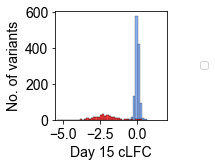

In [11]:
df=pd.read_csv(out_files+'Revised/Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', header=0, sep='\t',index_col=False)
df=df.query('Variant_design_type!="snvre"')

Nons_syn =df.query('Primary_consequence == "stop_gained" or Primary_consequence == "synonymous_variant"')
color_dict = {'stop_gained':'red', 'synonymous_variant':'cornflowerblue'}
fig, ax = plt.subplots()
ax.set_xlabel('Day 15 cLFC', fontsize=14)
ax.set_ylabel('No. of variants', fontsize=14)
ax.set_xlim(-5.5,2)
#ax.set_ylim(0,500)
fig.set_size_inches(2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g=sns.histplot(data=Nons_syn, x="D15_combined_LFC", hue='Primary_consequence', palette=color_dict, binwidth=0.15, edgecolor="k", legend=False, multiple='stack', fill=True)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig(out_files+'/Fig2E_histplot_nons_syn.pdf', dpi=1300, bbox_inches='tight', transparent=True)
